# Hyperspectral Image Analysis - Classification

In [1]:
%%capture
!pip install --upgrade git+git://github.com/abraia/abraia-multiple.git

import os
from dotenv import load_dotenv
load_dotenv()

if not os.getenv('ABRAIA_KEY'):
    #@markdown <a href="https://abraia.me/console/settings" target="_blank">Get your ABRAIA_KEY</a>
    abraia_key = ''  #@param {type: "string"}
    %env ABRAIA_KEY=$abraia_key

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from multiple import Multiple, hsi

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

multiple = Multiple()

## Download and read the HSI data

As an example, we'll use the Indian Pines (IP) Hyperspectral Image Dataset. It was gathered using the AVIRIS sensor over the Indian Pines test site in North-western Indiana and it consists of images of 145 X 145 pixels and 200 spectral bands, with 16 labels over the image. Here are the Ground Truth details of the IP dataset:

![]()https://miro.medium.com/max/775/1*XFC1rD8kpAxowJGuCch3ow.png

*Ground Truth Details of Indian Pines (IP) Dataset*

In [ ]:
#@markdown Get the IP dataset or <a href="https://abraia.me/console/gallery" target="_blank">Upload your hyperspectral data</a>
if not os.path.exists('Indian_pines_corrected.mat') or not os.path.exists('Indian_pines_gt.mat'):
    !wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
    !wget http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
try:
  multiple.upload('Indian_pines_corrected.mat')
  multiple.upload('Indian_pines_gt.mat')
except:
  print("Upload failed!")
  print("Check that you have a valid API Key")

In [3]:
hsiImg = multiple.load_image('Indian_pines_corrected.mat')
gt = multiple.load_image('Indian_pines_gt.mat')

print(f'HSI image size (width, height, #bands): {hsiImg.shape}')
print(f'Ground truth image size (width, height): {gt.shape}')

HSI image size (width, height, #bands): (145, 145, 200)
Ground truth image size (width, height): (145, 145)


## Visualize bands and ground truth

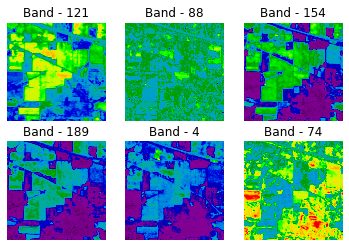

In [6]:
# Some random bands
imgs, indexes = hsi.random(hsiImg)
ax = plt.subplots(2, 3)[1].reshape(-1)
#print(f'Band - {indexes[0]}')
for i, img in enumerate(imgs):
    #label = 
    ax[i].title.set_text(f'Band - {indexes[i]}')
    ax[i].imshow(img, cmap='nipy_spectral')
    ax[i].axis('off')

(-0.5, 144.5, 144.5, -0.5)

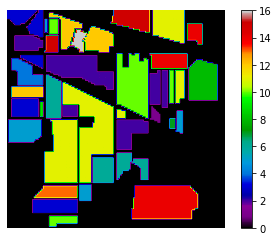

In [7]:
# Ground truth
plt.imshow(gt, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')

## Redundancy analysis with PCA

First, we analyze the redundancy in the data available using PCA decomposition.

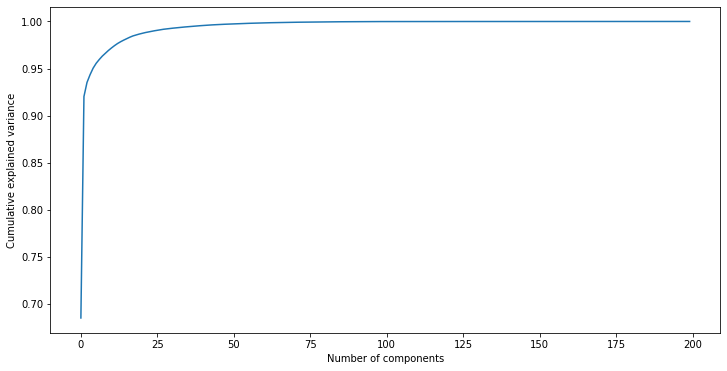

In [19]:
from sklearn.decomposition import PCA

# Transform image to array of samples (with corresponding spectra) and ground truth to array of labels 
X, y = hsiImg, gt
r, c, d = X.shape
X = X.reshape((r * c), d)
y = y.reshape((r * c))

pca = PCA()
pcX = pca.fit_transform(X)
ev=pca.explained_variance_ratio_

cumulativeVar = np.cumsum(ev)

plt.figure(figsize=(12, 6))
plt.plot(cumulativeVar)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

The curve shows that practically all variance is explained with the first 50 principal components. The rest of them are likely to contain mostly noise.

We can also visualize the first principal components of the spectral bands. As we see, components with lower variance values appear more and more noisy.

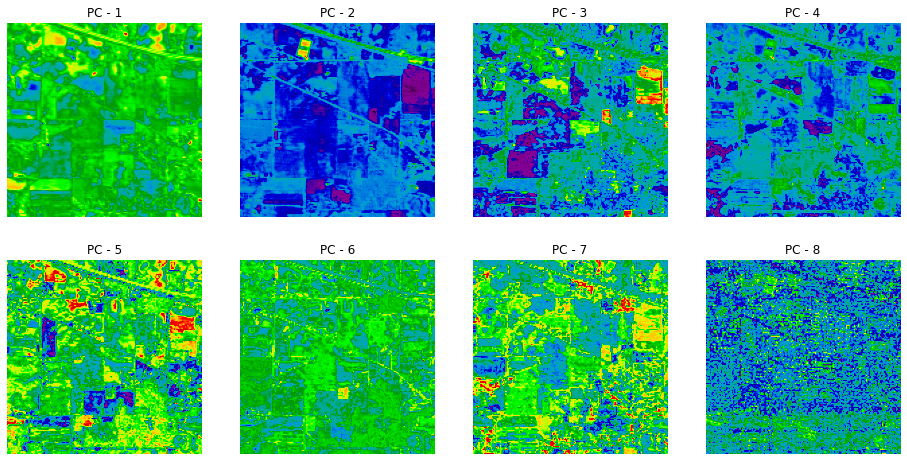

In [20]:
pca = PCA(n_components=40)
pcX = pca.fit_transform(X)
pcX = pcX.reshape(r, c, 40)

fig = plt.figure(figsize=(16,8))
for i in range(1, 1+8):
    fig.add_subplot(2,4, i)
    plt.title(f"PC - {i}")
    plt.imshow(pcX[:,:,i], cmap='nipy_spectral')
    plt.axis('off')

# Preprocessing and SVM training




We may simplify the job to the SVM model by reducing redundancy and decorrelation across spectral bands.

We can do it by learning a principal components decomposition before training our clasifier. This transformation will be stored as a preprocessing step to feed our model and will be also applied in the prediction phase.

We can reduce the number of features fed to the classifier, removing noise and irrelevant information that won't improve the performance of our clasifier. But even if we don't want to apply a reduction of the number of components, decorrelating the bands before feeding the classifier is a good practice with classic classfifiers like support vector machines. With the IP dataset, it improves performace by a 10%.

In [21]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# Preparing data for training and testing
class_names = ['', 'Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn', 'Grass-pasture','Grass-trees', 'Grass-pasture-mowed', 'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill', 'Soybean-clean', 'Wheat', 'Woods', 'Buildings Grass Trees Drives', 'Stone Steel Towers']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11, stratify=y)

# Training the model

nComp = 100

pca2 = PCA(n_components=nComp)
pca2.fit(X_train)
pcX_train = pca2.transform(X_train)

svm =  SVC(C=150, kernel='rbf', cache_size=10*1024)
svm.fit(pcX_train, y_train)

pcX_test = pca2.transform(X_test)
y_pred = svm.predict(pcX_test)

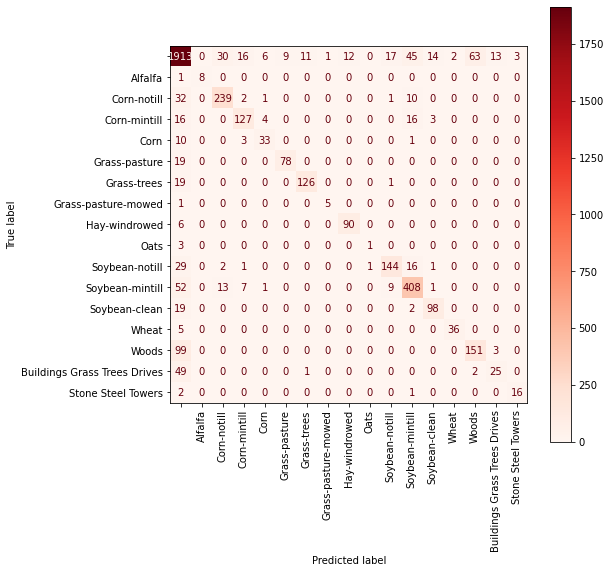

In [22]:
np.set_printoptions(precision=2)
plt.figure(figsize=(8, 8))
disp = plot_confusion_matrix(svm, pcX_test, y_test, display_labels=class_names, cmap=plt.cm.Reds, xticks_rotation='vertical', ax=plt.subplot())
disp.confusion_matrix

plt.show()

In [23]:
print(classification_report(y_test, y_pred, target_names=class_names))

                              precision    recall  f1-score   support

                                   0.84      0.89      0.86      2155
                     Alfalfa       1.00      0.89      0.94         9
                 Corn-notill       0.84      0.84      0.84       285
                Corn-mintill       0.81      0.77      0.79       166
                        Corn       0.73      0.70      0.72        47
               Grass-pasture       0.90      0.80      0.85        97
                 Grass-trees       0.91      0.86      0.89       146
         Grass-pasture-mowed       0.83      0.83      0.83         6
               Hay-windrowed       0.88      0.94      0.91        96
                        Oats       0.50      0.25      0.33         4
              Soybean-notill       0.84      0.74      0.79       194
             Soybean-mintill       0.82      0.83      0.82       491
               Soybean-clean       0.84      0.82      0.83       119
                   

### Classification Map

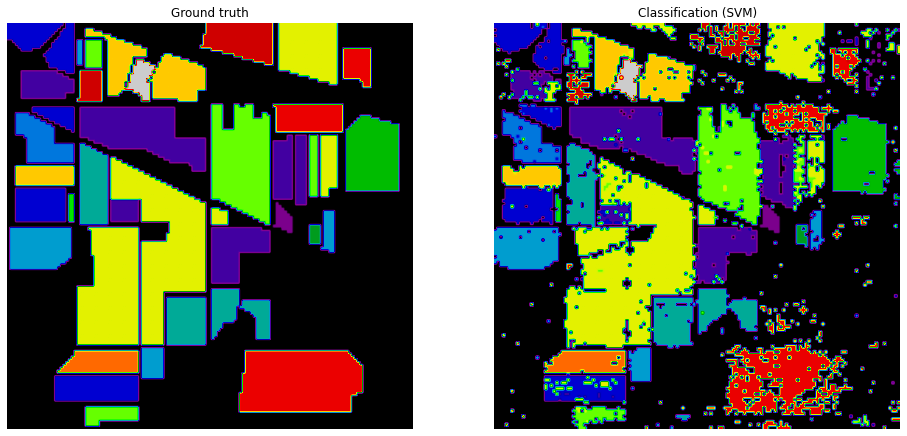

In [24]:
pcX = pca2.transform(X)
clmap = svm.predict(pcX).reshape(r, c)

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title('Ground truth')
plt.imshow(gt, cmap='nipy_spectral')
plt.axis('off')
plt.subplot(122)
plt.title('Classification (SVM)')
plt.imshow(clmap, cmap='nipy_spectral')
plt.axis('off')
plt.show()